I compared the sentiment scores of the JoeBiden and realDonaldTrump
twitter feeds. It seems that if anything, Biden is more neutral whereas Trump
falls into negative or positive polarisation more often. Trump seems to be
especially more positive in the upper quartile of the pos distribution.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from src.data.reader import TwitterReader, CSSEReader
sns.set(style='ticks', context='notebook')

Biden

In [2]:
reader = TwitterReader(dirname='twitter_user')
d = reader.read_sentiments()
biden = d['JoeBiden']

# smooth
window = "3d"
win_type = None
biden_mean = biden.rolling(window=window, center=False, win_type=win_type).mean()
biden_sd = biden.rolling(window=window, center=False, win_type=win_type).std()

/Users/felix/miniconda3/envs/bd4pp/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a150090>,
      dtype=object)

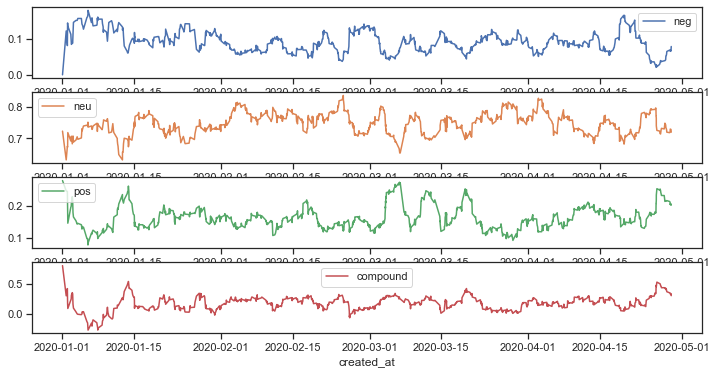

In [3]:
# plot
fig, ax = plt.subplots(figsize=(12,6))
#biden.plot(yerr=biden_sd, capsize=4,capthick=1, subplots=True, ax=ax)
biden_mean.plot(subplots=True, ax=ax)

Trump

/Users/felix/miniconda3/envs/bd4pp/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1059ff710>,
      dtype=object)

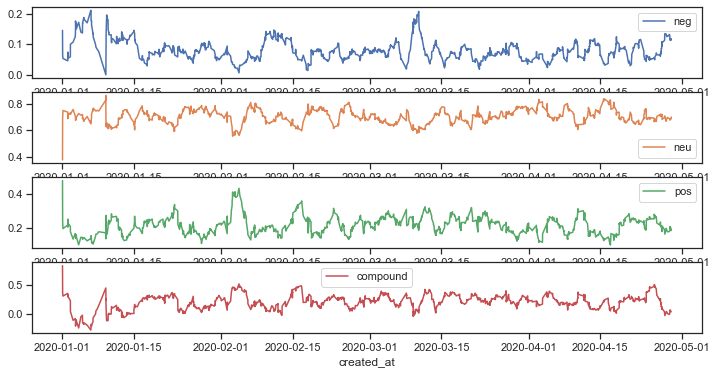

In [4]:
reader = TwitterReader(dirname='twitter_user')
d = reader.read_sentiments()
trump = d['realDonaldTrump']

# smooth
window = "2d"
trump_mean = trump.rolling(window=window, center=False).mean()
trump_sd = trump.rolling(window=window, center=False).std()

# plot
fig, ax = plt.subplots(figsize=(12,6))
#biden.plot(yerr=biden_sd, capsize=4,capthick=1, subplots=True, ax=ax)
trump_mean.plot(subplots=True, ax=ax)

Violinplots of sentiment score distribution

Text(0.5, 1.0, 'JoeBiden')

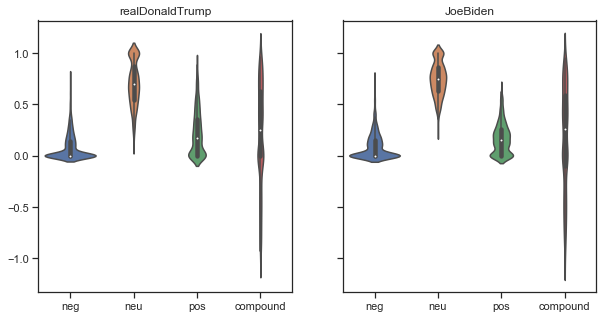

In [5]:
f, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)

sns.violinplot(data=trump, ax=axes[0])
axes[0].set_title("realDonaldTrump")

sns.violinplot(data=biden, ax=axes[1])
axes[1].set_title("JoeBiden")

In [6]:
print("Trump\n", trump.describe())
print("\nBiden\n", biden.describe())

Trump
                neg          neu          pos     compound
count  1521.000000  1521.000000  1521.000000  1521.000000
mean      0.080657     0.701133     0.218211     0.198887
std       0.124450     0.214283     0.216630     0.491720
min       0.000000     0.120000     0.000000    -0.957100
25%       0.000000     0.545000     0.000000     0.000000
50%       0.000000     0.694000     0.176000     0.250000
75%       0.139000     0.874000     0.361000     0.624900
max       0.765000     1.000000     0.880000     0.964300

Biden
                neg          neu          pos     compound
count  1052.000000  1052.000000  1052.000000  1052.000000
mean      0.088340     0.746804     0.164858     0.179285
std       0.120985     0.161908     0.148596     0.492022
min       0.000000     0.244000     0.000000    -0.965700
25%       0.000000     0.629000     0.000000    -0.102700
50%       0.000000     0.749500     0.147000     0.256050
75%       0.154000     0.861250     0.254250     0.585900

Read JHU CSSE data

In [16]:
csse = CSSEReader('csse')
csse_data = csse.read_processed_nc()

In [18]:
csse_agg = csse_data.sum(dim='county')
print(csse_agg)


<xarray.Dataset>
Dimensions:    (time: 98)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-22 2020-01-23 ... 2020-04-28
Data variables:
    confirmed  (time) int64 1 1 2 2 5 5 ... 903640 936362 963965 986348 1010692
    deaths     (time) int64 0 0 0 0 0 0 ... 49679 51447 53705 54829 56202 58296
